In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import copy
import cv2
import re
from PIL import Image

import sklearn
import sklearn.cluster
from skimage import measure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [ ]:
def segment(image,img, tosave=False, path=None, figIndex=0):
  #---------------
  #segmentation 
  D = 10
  sm_img = img[::D,::D,:]
  rgb = sm_img.reshape((-1,3))
  np.shape(rgb)
  kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb) 

  rgb = img.reshape((-1,3))
  kmeans = sklearn.cluster.KMeans(n_clusters=2,init=kmeans.cluster_centers_).fit(rgb)

  pred = kmeans.predict(rgb)
  res = pred.reshape((300,600))
  np.shape(res)

  #---------------
  #patch detection 
  regions = measure.label(res,connectivity=1,background=-10)
  patches = measure.regionprops(regions)
  img_area = np.shape(img)[0]*np.shape(img)[1]

  selected_patches = []
  for i in range(len(patches)):
      lying_flat = (patches[i].bbox[3]-patches[i].bbox[1])/(patches[i].bbox[2]-patches[i].bbox[0])
      if (patches[i].area > 100 and
          patches[i].area < 0.9*img_area and
          0.5 < lying_flat < 1.1):
          selected_patches.append(patches[i])

  #---------------
  #circle detection 
  #https://www.geeksforgeeks.org/circle-detection-using-opencv-python/

  gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_blurred = cv2.blur(gimg, (3, 3)) 

  # Apply Hough transform on the blurred image. 
  detected_circles = cv2.HoughCircles(gray_blurred,  
                    cv2.HOUGH_GRADIENT, 0.2, 20, param1 = 100, 
                param2 = 35, minRadius = 10, maxRadius = 60)

  # Draw circles that are detected. 
  if detected_circles is not None: 
      # Convert the circle parameters a, b and r to integers. 
      detected_circles = np.uint16(np.around(detected_circles))

  #---------------
  #slect intersecting patches and circles
  rectBorders = []
  selectedCircles = []
  for i in range(len(selected_patches)):
      x = selected_patches[i].bbox[1]
      y = selected_patches[i].bbox[0]
      width = selected_patches[i].bbox[3] - selected_patches[i].bbox[1]
      height = selected_patches[i].bbox[2] - selected_patches[i].bbox[0]

      for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
        if (a<selected_patches[i].bbox[3] and a>selected_patches[i].bbox[1] and
            b<selected_patches[i].bbox[2] and b>selected_patches[i].bbox[0] and
            abs(selected_patches[i].bbox[3]-a) >=r/3 and 
            abs(selected_patches[i].bbox[3]-a) <2*r and
            abs(selected_patches[i].bbox[1]-a) >=r/3 and
            abs(selected_patches[i].bbox[1]-a) <2*r and
            abs(selected_patches[i].bbox[2]-b) >=r/3 and
            abs(selected_patches[i].bbox[2]-b) <2*r and
            abs(selected_patches[i].bbox[0]-b) >=r/3 and
            abs(selected_patches[i].bbox[0]-b) <2*r and
            2*r < 1.8*height and
            2*r > 0.2*height):
          # Draw the circumference of the circle. 
          cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
          # Draw a small circle (of radius 1) to show the center. 
          cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
          selectedCircles.append([a,b,r])
          if (matplotlib.patches.Rectangle((x, y), width, height, edgecolor="red", linewidth=2, fill=False) not in rectBorders):
            rectBorders.append(matplotlib.patches.Rectangle((x, y), width, height, edgecolor="red", linewidth=2, fill=False))
  #if no patch detected: investigate all circles           
  if rectBorders == []:
    for pt in detected_circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2]
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        selectedCircles.append([a,b,r])      
  
  fig, (ax1) = plt.subplots(1,figsize=(10,10))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);
  for i in range(len(rectBorders)):
      ax1.add_patch(rectBorders[i])
  if tosave == True:
    plt.savefig(path+'segmentedImage'+figIndex+'.jpg')
  plt.close(fig)

  return selectedCircles

In [ ]:
#crop all selected circles with the bounding square, resize it to 100x100
def crop_image(image, img, circle):
  #https://stackoverflow.com/questions/36911877/cropping-circle-from-image-using-opencv-python
  mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
  circle_img = cv2.circle(mask,(circle[0],circle[1]),circle[2],(255,255,255),thickness=-1)
  masked_data = cv2.bitwise_and(image, image, mask=circle_img).copy()
  _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
  contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  x,y,w,h = cv2.boundingRect(contours[0][0])
  crop = np.array(masked_data[y:y+h,x:x+w])
  
  bg = np.ones_like(img, np.uint8)*255
  cv2.bitwise_not(bg,bg, mask=circle_img)
  crop2 = crop + np.array(bg[y:y+h,x:x+w])

  size = 100
  crop2 = cv2.resize(crop2,(size,size), interpolation=cv2.INTER_AREA)

  return crop2


In [ ]:
#https://stackoverflow.com/questions/3157374/how-do-you-remove-a-numpy-array-from-a-list-of-numpy-arrays
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

In [ ]:
#classification of the cropped images 
def classif(image, img, selectedCircles, isimshow=False):
  traffSigns = []
  detectedCategories = []
  size = 100

  # https://pysource.com/2019/02/15/detecting-colors-hsv-color-space-opencv-with-python/
  #RED filter
  low_red = np.array([100, 100, 60])
  high_red = np.array([170, 250, 255])

  for circle in selectedCircles:
    crop = crop_image(image, img, circle)
    hsv_frame = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    red_mask = cv2.inRange(hsv_frame, low_red, high_red)

    # looking for Red (if not enough, not a traffic sign)
    red = cv2.bitwise_and(crop, crop, mask=red_mask)

    #-----------------------------
    #looking for white rectangle in the middle (Category D)
    #-----------------------------
    if np.mean(red) >= 50:
      #make template for no entry sign
      noEntry = mpimg.imread("d.jpg")
      noEntry = cv2.resize(noEntry,(size,size), interpolation=cv2.INTER_AREA)
      noEntry = cv2.cvtColor(noEntry, cv2.COLOR_BGR2GRAY)
      noEntryTemplate = noEntry[20:80,45:55]

      gcrop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
      res = cv2.matchTemplate(gcrop,noEntryTemplate,cv2.TM_CCOEFF_NORMED)
      threshold = 0.75
      loc = np.where( res >= threshold)
      if loc != []:
        detectedCategories.append('D')
    
    #build a list for further classification
    elif np.mean(red) >= 4.5:
      traffSigns.append(crop)
      
  #-----------------------------
  #looking for blue (Category E)
  #-----------------------------
  #BLUE filter
  low_blue = np.array([2, 150, 50])
  high_blue = np.array([100, 255, 200])

  for crop in traffSigns:
    hsv_frame = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(crop, crop, mask=blue_mask)
    if isimshow == True:
      figure_size = 5
      plt.figure(figsize=(figure_size,figure_size))
      plt.subplot(1,2,1),plt.imshow(crop)
      plt.title("Category E")
      plt.subplot(1,2,2),plt.imshow(blue)
      plt.show()  
      print('mean(blue)= '+str(np.mean(blue)))
    
    if np.mean(blue) >= 10:
      detectedCategories.append('E')
      removearray(traffSigns,crop)

  
  #-----------------------------
  #looking for red strikethrough (Categoey A)
  #-----------------------------
  # -   rotate the image by -30 degrees
  # -   check the red part of the band of width 20 in the middle
  for crop in traffSigns:
    hsv_frame = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    red_mask = cv2.inRange(hsv_frame, low_red, high_red)
    red = cv2.bitwise_and(crop, crop, mask=red_mask)
    imgStrike = copy.deepcopy(red)
    image_center = tuple(np.array(imgStrike.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -30, 1.0)
    imgRotated = cv2.warpAffine(imgStrike, rot_mat, imgStrike.shape[1::-1], flags=cv2.INTER_LINEAR)
    imgRotatedCroped = imgRotated[:,40:60] 

    #check the mean of each row
    strikeMeasure = sum([0 if  sum(sum(row)) == 0 else 1 for row in imgRotatedCroped])
    if strikeMeasure >= 65:
      detectedCategories.append('A')
      removearray(traffSigns,crop)
    if isimshow == True:
      figure_size = 5
      plt.figure(figsize=(figure_size,figure_size))
      plt.subplot(1,3,1),plt.imshow(crop)
      plt.title("Category A")
      plt.subplot(1,3,2),plt.imshow(red)
      plt.subplot(1,3,3),plt.imshow(imgRotatedCroped)
      plt.show()  
      print('strikeMeasure= '+str(strikeMeasure))


  #-----------------------------
  #looking for white circle (Category C)
  #-----------------------------
  for crop in traffSigns:
    gcrop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.blur(gcrop, (3, 3)) 
    cropCopy = copy.deepcopy(crop)

    # Apply Hough transform on the blurred image. 
    detected_circles = cv2.HoughCircles(gray_blurred,  
                      cv2.HOUGH_GRADIENT, 1, 50, param1 = 130, 
                  param2 = 20, minRadius = 20, maxRadius = 40)

    if detected_circles is not None: 
      detected_circles = sorted(detected_circles[0],key=lambda x:x[2],reverse=True)
      # Convert the circle parameters a, b and r to integers. 
      detected_circles = np.uint16(np.around(detected_circles))

      #for pt in detected_circles[0, :]: 
      pt = detected_circles[-1]
      a, b, r = pt[0], pt[1], pt[2] 
      if (2*r < 0.8*size and
          2*r > 0.2*size):
        # Draw the circumference of the circle. 
        cv2.circle(cropCopy, (a, b), r, (0, 255, 0), 2)
        crop2 = copy.deepcopy(crop)
        miniCrop = crop_image(cropCopy,crop2,[a,b,r])
        hsv_frame = cv2.cvtColor(miniCrop, cv2.COLOR_BGR2HSV)
        low_white = np.array([0, 0, 120])
        high_white = np.array([130, 120, 190])
        white_mask = cv2.inRange(hsv_frame, low_white, high_white)
        white = cv2.bitwise_and(miniCrop, miniCrop, mask=white_mask)
        if isimshow == True:
          figure_size = 5
          plt.figure(figsize=(figure_size,figure_size))
          plt.subplot(1,2,1)
          plt.title("Category C")
          plt.imshow(miniCrop)
          plt.subplot(1,2,2),plt.imshow(white)
          plt.show()  
        
        # percentage of white area in the detected circle
        whitePart = np.count_nonzero(white)/3/(50**2*math.pi)
        if whitePart >= 0.6:
          detectedCategories.append('C')
          removearray(traffSigns,crop)

  #-----------------------------
  # filter the speed limit (Category B)
  #-----------------------------
  # use template matching for the 0
  zero = np.array(Image.open("b.png").convert('RGB'))
  zero = cv2.resize(zero,(size,size), interpolation=cv2.INTER_AREA)
  zero = cv2.cvtColor(zero, cv2.COLOR_BGR2GRAY)
  zeroTemplate = zero[28:71,51:77]

  for crop in traffSigns:
    detectedB = False
    gcrop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    image_center = tuple(np.array(zeroTemplate.shape[1::-1]) / 2)
    threshold = 0.65
    for i in range(-20,20,2):
      rot_mat = cv2.getRotationMatrix2D(image_center, i, 1.0)
      zeroTemplateRotated = cv2.warpAffine(np.invert(zeroTemplate), rot_mat, zeroTemplate.shape[1::-1], flags=cv2.INTER_LINEAR)
      res = cv2.matchTemplate(gcrop,zeroTemplateRotated,cv2.TM_CCOEFF_NORMED)
      loc = np.where( res >= threshold)
      if loc != []:
        for item in loc:
          if item != []:
            detectedB = True

    #2nd try with rescaled template (0.8)
    if detectedB == False:
      h,w = zeroTemplate.shape
      zeroTemplate = cv2.resize(zeroTemplate,(int(w*0.8),int(h*0.8)), interpolation=cv2.INTER_AREA)
      for i in range(-20,20,2):
        rot_mat = cv2.getRotationMatrix2D(image_center, i, 1.0)
        zeroTemplateRotated = cv2.warpAffine(np.invert(zeroTemplate), rot_mat, zeroTemplate.shape[1::-1], flags=cv2.INTER_LINEAR)
        res = cv2.matchTemplate(gcrop,zeroTemplateRotated,cv2.TM_CCOEFF_NORMED)
        loc = np.where( res >= threshold)
        if loc != []:
          for item in loc:
            if item != []:
              detectedB = True
    
    #3rd try with rescaled template (0.7)
    if detectedB == False:
      h,w = zeroTemplate.shape
      zeroTemplate = cv2.resize(zeroTemplate,(int(w*0.7),int(h*0.7)), interpolation=cv2.INTER_AREA)
      for i in range(-20,20,2):
        rot_mat = cv2.getRotationMatrix2D(image_center, i, 1.0)
        zeroTemplateRotated = cv2.warpAffine(np.invert(zeroTemplate), rot_mat, zeroTemplate.shape[1::-1], flags=cv2.INTER_LINEAR)
        res = cv2.matchTemplate(gcrop,zeroTemplateRotated,cv2.TM_CCOEFF_NORMED)
        loc = np.where( res >= threshold)
        if loc != []:
          for item in loc:
            if item != []:
              detectedB = True
    
    if detectedB == True:
      detectedCategories.append('B')
      removearray(traffSigns,crop)

  #-----------------------------
  # filter the rest (Category F)
  #-----------------------------
  low_grey = np.array([0, 0, 0])
  high_grey = np.array([110, 110, 110])
  grey_mask = cv2.inRange(hsv_frame, low_grey, high_grey)
  for crop in traffSigns:
    grey = cv2.bitwise_and(crop, crop, mask=grey_mask)
    if isimshow == True:
      figure_size = 5
      plt.figure(figsize=(figure_size,figure_size))
      plt.subplot(1,2,1),plt.imshow(crop)
      plt.title("Category F")
      plt.subplot(1,2,2),plt.imshow(grey)
      plt.show()  
      print('mean(grey)= '+str(np.mean(grey)))
    if np.mean(grey) > 5:
      detectedCategories.append('F')

  return(sorted(detectedCategories))


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


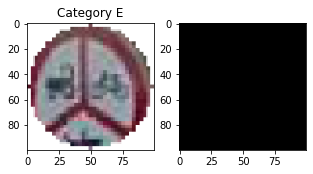

mean(blue) = 0.0


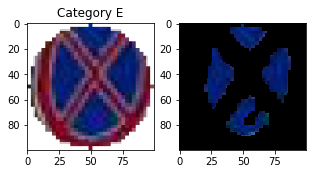

mean(blue) = 10.7595


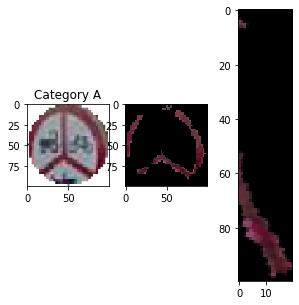

strikeMeasure= 52


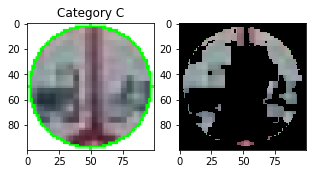

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:192: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


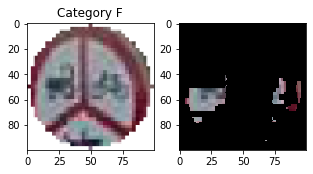

mean(grey)= 9.634266666666667
Traffic signs found: ['E', 'F']


In [ ]:
#demonstration
figure="/content/drive/My Drive/Data Challenge/training_images/8.jpg" #put your test image here
image = mpimg.imread(figure)
img = copy.deepcopy(image)
selectedCircles = segment(image,img,tosave=False)
classes = classif(image,img,selectedCircles,isimshow=True)
print('Traffic signs found: ' + str(classes))

In [ ]:
#classification of the training images
#see result in segmented_images folder
path="/content/drive/My Drive/Data Challenge/training_images/"
classes = {}
for figind in range(20):
  figure = str(figind+1)+ ".jpg"
  image = mpimg.imread(path+figure)
  img = copy.deepcopy(image)
  #process
  selectedCircles = segment(image,img, tosave=True, path, str(figind+1))
  classes[str(figind+1)] = classif(image,img,selectedCircles,isimshow=False)
  #print(classif(image,img,selectedCircles,isimshow=False))
  #classes.append(classif(image,img,selectedCircles,isimshow=False))
  #classif(image,img,selectedCircles,isimshow=True)
print(k+': '+ v for k,v in classes.items())